In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from rich.table import Table
import matplotlib.pyplot as plt
from matplotlib import gridspec
from wordcloud import WordCloud
from rich.console import Console
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
steam_games = pd.read_csv("games.csv")
user_item_matrix = pd.read_csv("user_item_matrix.csv")

In [3]:
steam_games['app_id'] = steam_games['app_id'].astype(int)
user_item_matrix['app_id'] = user_item_matrix['app_id'].astype(int)

user_ids = user_item_matrix['user_id'].astype('category')
app_ids = user_item_matrix['app_id'].astype('category')

sparse_matrix = coo_matrix((user_item_matrix['is_recommended'],
                            (user_ids.cat.codes, app_ids.cat.codes)),
                            shape=(user_ids.cat.categories.size, app_ids.cat.categories.size))

In [4]:
sparse_matrix_csr = sparse_matrix.tocsr()

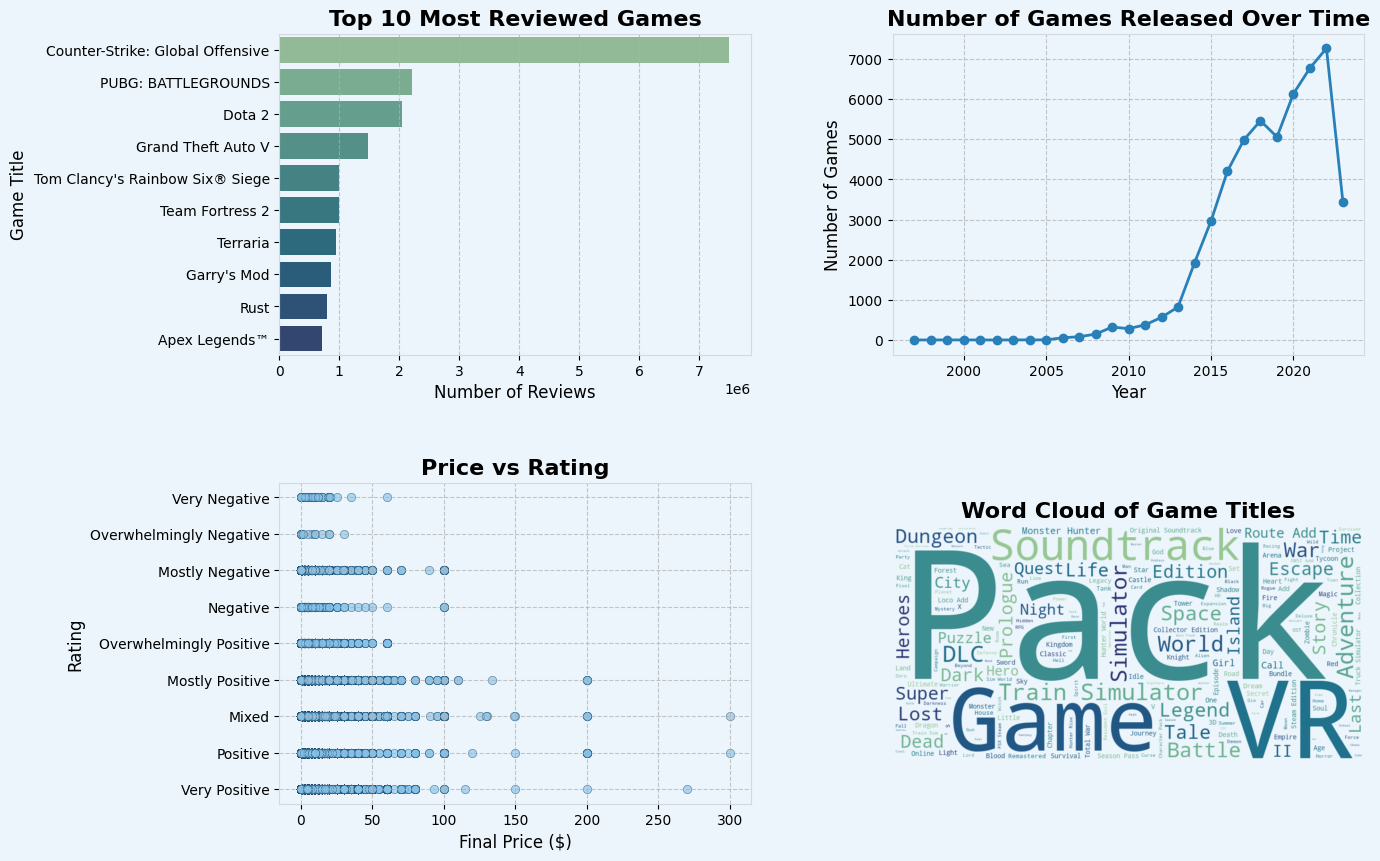

In [5]:
top_reviewed_games = steam_games.nlargest(10, 'user_reviews')
steam_games['date_release'] = pd.to_datetime(steam_games['date_release'])
games_per_year = steam_games['date_release'].dt.year.value_counts().sort_index()
text = ' '.join(steam_games['title'].dropna())

fig = plt.figure(figsize=(14, 10), facecolor='#ebf5fb')
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], hspace=0.4, wspace=0.3)

# Plot 1: Top 10 Most Reviewed Games
ax1 = fig.add_subplot(gs[0, 0])
palette = sns.color_palette("crest", n_colors=len(top_reviewed_games))
sns.barplot(data=top_reviewed_games, x='user_reviews', y='title', palette=palette, hue='title', dodge=False,ax=ax1, legend=False)
ax1.set_title('Top 10 Most Reviewed Games', fontsize=16, fontweight='bold')
ax1.set_xlabel('Number of Reviews', fontsize=12)
ax1.set_ylabel('Game Title', fontsize=12)
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.set_facecolor('#ebf5fb')
for spine in ax1.spines.values():
    spine.set_color('#d5d8dc')

# Plot 2: Price vs Rating
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(steam_games['price_final'], steam_games['rating'], alpha=0.6, 
            color='#85c1e9', edgecolor='#1b4f72', linewidth=0.5)
ax2.set_title('Price vs Rating', fontsize=16, fontweight='bold')
ax2.set_xlabel('Final Price ($)', fontsize=12)
ax2.set_ylabel('Rating', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_facecolor('#ebf5fb')
for spine in ax2.spines.values():
    spine.set_color('#d5d8dc')

# Plot 3: Number of Games Released Over Time
ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(games_per_year.index, games_per_year.values, color='#2980b9', linewidth=2, marker='o')
ax3.set_title('Number of Games Released Over Time', fontsize=16, fontweight='bold')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Number of Games', fontsize=12)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.set_facecolor('#ebf5fb')
for spine in ax3.spines.values():
    spine.set_color('#d5d8dc')

# Plot 4: Word Cloud of Game Titles
ax4 = fig.add_subplot(gs[1, 1])
wordcloud = WordCloud(width=1000, height=500, background_color='#ebf5fb', 
                      colormap='crest', margin=10).generate(text)
ax4.imshow(wordcloud, interpolation='bilinear')
ax4.axis('off')
ax4.set_title('Word Cloud of Game Titles', fontsize=16, fontweight='bold')

# Show the figure
plt.show()


In [6]:
item_similarity_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
item_similarity_model.fit(sparse_matrix_csr.T)
pd.options.mode.chained_assignment = None


def content_based_recommendation(app_id_input):
    try:
        if app_id_input not in steam_games['app_id'].values:
            raise ValueError(f"app_id {app_id_input} not found in the dataset.")
        
        item_id = app_ids.cat.codes[app_ids == app_id_input].values[0]
        item_vector = sparse_matrix_csr.T[item_id].toarray().flatten()
        distances, indices = item_similarity_model.kneighbors([item_vector], n_neighbors=10)
        recommended_app_ids = app_ids.cat.categories[indices.flatten()].tolist()
        
        recommended_games = steam_games[steam_games['app_id'].isin(recommended_app_ids)]
        game_name = steam_games.loc[steam_games['app_id'] == app_id_input, 'title'].values[0]
        print(f"\nRecommendations for {game_name} ({app_id_input}):")

        all_game_titles = [game_name] + recommended_games['title'].tolist()
        
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(all_game_titles)
        
        cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
        recommended_games.loc[:, 'similarity'] = cosine_sim
        recommended_games = recommended_games.sort_values(by='similarity', ascending=False)
        recommended_games = recommended_games[recommended_games['title'] != game_name]
        
        table = Table(show_header=True, header_style="bright_green")
        table.add_column("Game Title", justify="left", min_width=45, style="light_cyan1")
        table.add_column("Release Date", justify="center", min_width=10, style="light_green")
        table.add_column("Rating", justify="center", min_width=5, style="bright_cyan")
        table.add_column("Reviews", justify="center", min_width=10, style="magenta1")
        table.add_column("Price", justify="right", min_width=5, style="light_goldenrod1")
    
        for idx, game in enumerate(recommended_games.itertuples(), start=1):
            if (game.price_final == 0):
                price = "Free"
            else:
                price = '$' + str(game.price_final)
            
            release_date = game.date_release.strftime('%Y-%m-%d') if not pd.isnull(game.date_release) else "N/A"

            table.add_row(
                game.title,
                release_date,
                str(game.rating),
                str(game.user_reviews),
                price
            )
        
        console = Console()
        console.print(table)

    except ValueError as e:
        print(e)

In [7]:
def search_and_recommend(input_title, top_n=10):
    try:
        matching_games = steam_games[steam_games['title'].str.contains(input_title, case=False, na=False)]
        
        if not matching_games.empty:
            app_id_input = matching_games.iloc[0]['app_id']
            print(f"Closest match found: {matching_games.iloc[0]['title']}")
            content_based_recommendation(app_id_input)
        else:
            print(f"'{input_title}' not found in the dataset. Finding closest match...")

            vectorizer = TfidfVectorizer(stop_words='english')
            tfidf_matrix = vectorizer.fit_transform(steam_games['title'])
            input_vector = vectorizer.transform([input_title])
            
            cosine_similarities = cosine_similarity(input_vector, tfidf_matrix).flatten()

            most_similar_index = cosine_similarities.argmax()
            closest_game = steam_games.iloc[most_similar_index]

            print(f"Closest match found: {closest_game['title']} (app_id {closest_game['app_id']})")
            content_based_recommendation(closest_game['app_id'])  # Call the main function for recommendations

    except Exception as e:
        print(f"Error: {e}")

In [8]:
search_and_recommend("Red Dead")

Closest match found: Red Dead Redemption 2

Recommendations for Red Dead Redemption 2 (1174180):


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Game Title                                    ┃ Release Date ┃         Rating          ┃  Reviews   ┃ Price ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Far Cry® 5                                    │  2018-03-26  │      Very Positive      │   129943   │ $60.0 │
│ Grand Theft Auto V                            │  2015-04-13  │      Very Positive      │  1484122   │  Free │
│ The Witcher® 3: Wild Hunt                     │  2015-05-18  │ Overwhelmingly Positive │   668455   │ $40.0 │
│ Fallout 4                                     │  2015-11-09  │      Very Positive      │   205094   │ $20.0 │
│ Cyberpunk 2077                                │  2020-12-09  │      Very Positive      │   557051   │ $60.0 │
│ God of War                                    │  2022-01-14  │ Overwhelmingly Positive │   76981    │ $50.0 │
│ Mafia: Definitive Edition                     │  2020-09-24  │      Very Positive      │   46016    │ $40.0 │
│ STAR WARS Jedi: Fallen Order™                 │  2019-11-14  │      Very Positive      │   112350   │ $40.0 │
│ Marvel’s Spider-Man Remastered                │  2022-08-12  │ Overwhelmingly Positive │   53844    │ $60.0 │
└───────────────────────────────────────────────┴──────────────┴─────────────────────────┴────────────┴───────┘